# The Mott transition with the CT-INT solver

In [11]:
%matplotlib inline
import numpy as np
from triqs.gf import *
from h5 import *
import triqs.utility.mpi as mpi
from triqs.plot.mpl_interface import plt, oploti, oplotr

params = {'legend.fontsize': 'x-large',
          'figure.figsize': (10, 6),
          'axes.labelsize': 'x-large',
          'axes.titlesize':'xx-large',
          'xtick.labelsize':'x-large',
          'ytick.labelsize':'x-large'}
plt.rcParams.update(params)

Solution of the exercises
=========================

Solution of exercise 1
----------------------

The solution of this exercise is in the script called `run_single_band.py` in the tutorial directory. View it by executing the command below. 

In [3]:
from triqs_ctint import Solver

# Parameters of the model
t = 1.0
beta = 10.0
n_loops = 10
n_iw = 400
delta = 0.1
n_cycles = 50000

# Construct the impurity solver
S = Solver(beta, n_iw)

# I run for several values of U
for U in np.arange(1.0, 13.0):
    print('\n U =', U, '\n')

    # This is a first guess for G
    S.G_iw << SemiCircular(2*t)

    # DMFT loop with self-consistency
    for i in range(n_loops):
    
        print("Iteration = %i / %i" % (i+1, n_loops))
    
        # Symmetrize the Green's function and use self-consistency
        g = 0.5 * ( S.G_iw['up'] + S.G_iw['down'] )
        for name, g0 in S.G0_iw:
            g0 << inverse( iOmega_n + U/2.0 - t**2 * g )

        # Solve the impurity problem
        S.solve(U, delta, n_cycles)
    
        # Save iteration in archive
        with HDFArchive("results_U%.2f.h5"%U) as A:
            A['G0-%i'] = S.G0_iw
            A['G-%i'%i] = S.G_iw


U = 1.0


Iteration = 1 / 10


Iteration = 2 / 10


Iteration = 3 / 10


Iteration = 4 / 10


Iteration = 5 / 10


Iteration = 6 / 10


Iteration = 7 / 10


Iteration = 8 / 10


Iteration = 9 / 10


Iteration = 10 / 10
U = 2.0


Iteration = 1 / 10


Iteration = 2 / 10


Iteration = 3 / 10


Iteration = 4 / 10


Iteration = 5 / 10


Iteration = 6 / 10


Iteration = 7 / 10


Iteration = 8 / 10


Iteration = 9 / 10


Iteration = 10 / 10
U = 3.0


Iteration = 1 / 10


Iteration = 2 / 10


Iteration = 3 / 10


Iteration = 4 / 10


Iteration = 5 / 10


Iteration = 6 / 10


Iteration = 7 / 10


Iteration = 8 / 10


Iteration = 9 / 10


Iteration = 10 / 10
U = 4.0


Iteration = 1 / 10


Iteration = 2 / 10


Iteration = 3 / 10


Iteration = 4 / 10


Iteration = 5 / 10


Iteration = 6 / 10


Iteration = 7 / 10


Iteration = 8 / 10


Iteration = 9 / 10


Iteration = 10 / 10
U = 5.0


Iteration = 1 / 10


Iteration = 2 / 10


Iteration = 3 / 10


Iteration = 4 / 10


Iteration = 5 / 10


Iteration

RuntimeError: .. Error occurred at Sat Apr  3 23:29:16 2021

.. Error .. calling C++ overload 
.. solve(double U, double delta, int n_cycles, int length_cycle, int n_warmup_cycles, std::string random_name, int max_time) -> void 
.. in implementation of method Solver.solve
.. C++ error was : 
.. Triqs runtime error at /scratch/mferrero/ctint/install/include/triqs/mc_tools/mc_move_set.hpp : 204

Monte Carlo Error : the rate ((-nan,-nan)) is not finite in move insertion
.. Error occurred on node 0


The script saves the Green's functions and self-energies in archives in the subdirectory called `results`. They will be used for the analysis below. We study several values of $U$ to see how the Green's functions will change. Note that these runs takes a bit of time!

You can

- run this directly from the shell to see the Monte Carlo progress or 
- run the command below.

Solution of exercise 2
----------------------

Start by reading the data from the archive and plot it.

Text(0, 0.5, '$G(i\\omega_n)$')

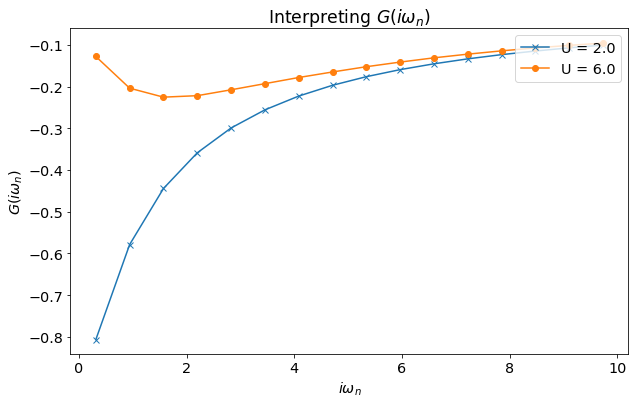

In [16]:
A1 = HDFArchive("results_U2.00.h5", 'r')
A2 = HDFArchive("results_U5.00.h5", 'r')

# Plot the Green's function of the last iteration
oploti(A1['G-9']['up'], '-x', x_window=(0,10), label='U = 2.0')
oploti(A2['G-9']['down'], '-o', x_window=(0,10), label='U = 6.0')

plt.title("Interpreting $G(i\omega_n)$")
plt.xlabel("$i\omega_n$")
plt.ylabel("$G(i\omega_n)$")

As you can see, the behavior of the imaginary part is very different for the two values of $U$. When
$U$ is small, the system is a metal and the imaginary part extrapolated to zero goes to a finite value.
Instead, for large $U$, the system is a Mott insulator and the imaginary part goes to zero. The reason
is that the extrapolation to zero is directly proportional to the density of states at the chemical
potential. If the system is gapped, the density is zero; if the system is a metal, there is spectral
weight and the density is finite. Therefore, even on the Matsubara axis, one has a way to decide if the
system is metallic or not.

Solution of exercise 3
----------------------

We now do the same for the self-energy.

In [ ]:
A1 = HDFArchive("results_one_band/half-U2.00.h5", 'r')
A2 = HDFArchive("results_one_band/half-U6.00.h5", 'r')

# Plot the self-energy of the last iteration
oplot(A1['Sigma-9']['up'].imag, 'x', name='U = 2.0')
oplot(A2['Sigma-9']['up'].imag, 'o', name='U = 6.0')

plt.xlim(0,5)
plt.ylim(-30,0)

Here the extrapolation to zero goes to zero for the metal and diverges in the insulator. In general, we expect that the
self-energy goes to zero linearly at small frequencies in a Fermi-liquid metal. As we will see below, the slope
tells something about the degree of correlation. In the Mott insulator, a gap open because of the development of a
pole in the self-energy. The manifestation of this pole is a diverging imaginary part of the self-energy a low frequencies
as is visible here.

Solution of exercise 4
----------------------

We estimate the derivative using the following approximation

$$
Z = \lim_{\omega_n \rightarrow 0} \Big( 1 - \frac{d\mathrm{Im} \Sigma(i\omega_n)}{di\omega_n} \Big)^{-1}
  \sim \Big( 1 - \frac{\mathrm{Im} \Sigma(i\omega_0)}{i\omega_0} \Big)^{-1}
$$

with $\omega_0 = \pi / \beta$ being the first Matsubara frequency.

In [ ]:
beta = 10
U_list = []
Z_list = []

for U in np.arange(1.0, 9.0):
    
    A = HDFArchive("results_one_band/half-U%.2f.h5"%U, 'r')
    Sigma = A['Sigma-9']
    
    Z = 1 / (1 - (Sigma['up'](0)[0,0].imag * beta / np.pi))
    U_list.append(U)
    Z_list.append(Z)
    
plt.plot(U_list, Z_list, '-o')
plt.xlabel('U')
plt.ylabel('Z')

Solution of exercise 5
----------------------

This is just the same script as we had earlier. We just add a couple of lines to extract $Z$.

1.0
0.92476478016611
0.7405705430914732
0.5233633052723822
0.3175449864577424
0.04849118119203953
0.017584057176008857
0.010908997591308934
0.00765835533691361
0.005741319986992433
0.004491275901798295
0.003621997137791201


NameError: name 'U_list' is not defined

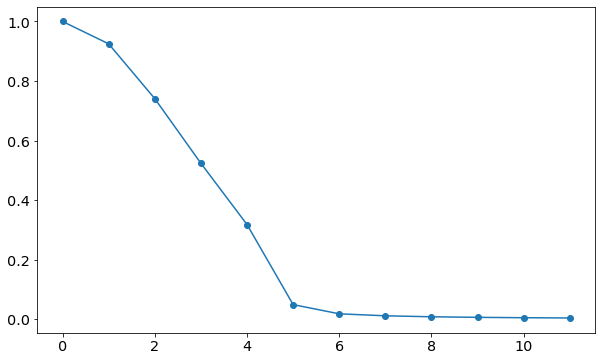

In [23]:
from triqs.gf import *
from triqs.plot.mpl_interface import *

class IPTSolver:

    def __init__(self, beta):

        self.beta = beta

        # Matsubara frequency
        self.g = GfImFreq(indices=[0], beta=beta, name='0')
        self.g0 = self.g.copy()
        self.sigma = self.g.copy()
        
        # Imaginary time
        self.g0t = GfImTime(indices=[0], beta = self.beta, name='G0t')
        self.sigmat = self.g0t.copy()
        
    def solve(self, U):

        self.g0t << Fourier(self.g0)
        self.sigmat << (U**2) * self.g0t * self.g0t * self.g0t
        self.sigma << Fourier(self.sigmat)

        # Dyson
        self.g << self.g0 * inverse(1.0 - self.sigma * self.g0)
        

t = 1.0
beta = 10
n_loops = 30

S = IPTSolver(beta = beta)

U_list2 = []
Z_list2 = []

for U in np.arange(0.0, 12.0):
    
    S.g << SemiCircular(2*t)
    for i in range(n_loops):

        S.g0 << inverse( iOmega_n - t**2 * S.g )
        S.solve(U = U)
    

    Z = 1 / (1 - (S.sigma(0)[0,0].imag * beta / np.pi))
    U_list2.append(U)
    Z_list2.append(Z)
    
    print(Z)
    
plt.plot(U_list2, Z_list2, '-o', label='IPT')
plt.plot(U_list, Z_list, '-x', label='CTQMC')
plt.xlabel('U')
plt.ylabel('Z')
plt.legend()

Solution of exercise 6
----------------------


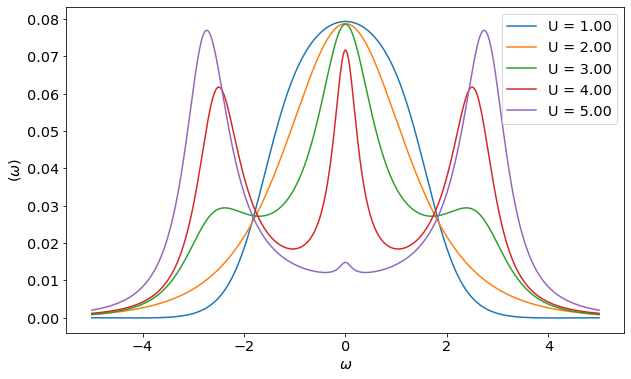

In [50]:
for U in np.arange(1,6):
    with HDFArchive("results_U%.2f.h5"%U, 'r') as A:
        for i in range(5,10):
            if i ==0:
                g = A['G-%i'%i]['up']
            else:
                g += A['G-%i'%i]['up']
            g /= 5
        # impose real part = 0
        g.data[:] = 0.5 * ( g.data - g.data.conjugate() )

    g_real = GfReFreq(indices=[0], window=[-5,5])
    g_real.set_from_pade(g)
    oplot(-g_real.imag/np.pi, label="U = %.2f"%U)

The result is completely wrong. This is because of the noise in the Monte Carlo data. One would have to make much longer runs in order to reduce the error bars. The Pade approximation can be used only on very accurate data. When the noise is still quite large, one has to use different analytical continuation methods, like MaxEnt, which produces the following spectral function:

<img src="files/maxent_Aw.png">

However, TRIQS does not provide a MaxEnt package. Regardless of which package you use for MaxEnt, it is very important to remember that there are some important knobs with which one can play in MaxEnt that can substantially change the results, and so one must be very careful in its use!